In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial import Voronoi, voronoi_plot_2d

import py4DSTEM

In [2]:
fp = "/home/ben/Data/20190128_ClassificationData/EASY_binDiffraction4.h5"
browser = py4DSTEM.file.readwrite.FileBrowser(fp)
ave_im = browser.get_dataobject('average_image').data2D
deconvolution = browser.get_dataobject('deconvolution').data2D
braggpeaks = browser.get_dataobject('Bragg_peaks')
browser.close()

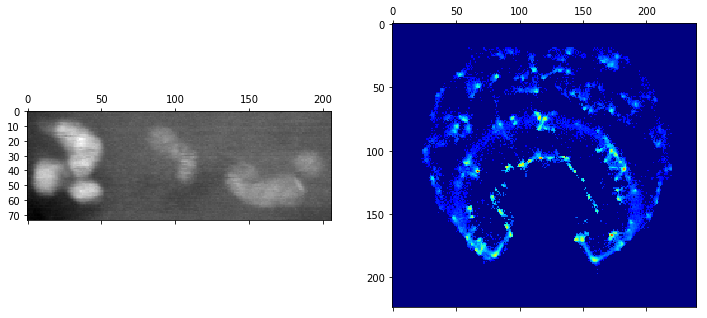

In [6]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax2.matshow(deconvolution**0.2,cmap='jet')
plt.show()

#### Classify diffraction space
w/ a Voronoi diagram about average deconvolution maxima

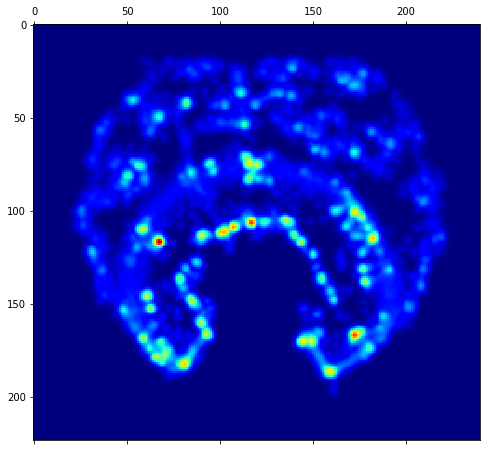

In [11]:
# Make smoothed deconvolution

sigma=1
deconvolution_smoothed = gaussian_filter(deconvolution,sigma)

fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(deconvolution_smoothed**0.25,cmap='jet')
plt.show()

In [12]:
# Get maxima

maxima = py4DSTEM.process.utils.get_maximal_points(deconvolution_smoothed)
max_point_indices_x, max_point_indices_y = np.nonzero(maxima)
point_intensities = deconvolution_smoothed[max_point_indices_x,max_point_indices_y]

coords = [('qx',float),('qy',float),('intensity',float)]
deconvolution_peaks = py4DSTEM.file.datastructure.PointList(coordinates=coords)
length = len(point_intensities)
for i in range(length):
    new_point = (max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
    deconvolution_peaks.add_point(new_point)

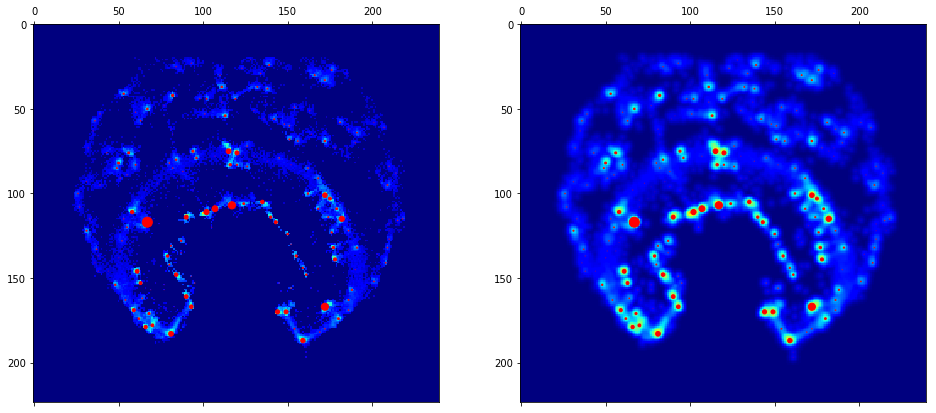

In [16]:
# Show
scale=100

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**0.25,cmap='jet')
ax1.scatter(deconvolution_peaks.data['qy'],deconvolution_peaks.data['qx'],color='r',
            s=scale*deconvolution_peaks.data['intensity']/np.max(deconvolution_peaks.data['intensity']))
ax2.matshow(deconvolution_smoothed**0.25,cmap='jet')
ax2.scatter(deconvolution_peaks.data['qy'],deconvolution_peaks.data['qx'],color='r',
            s=scale*deconvolution_peaks.data['intensity']/np.max(deconvolution_peaks.data['intensity']))
plt.show()

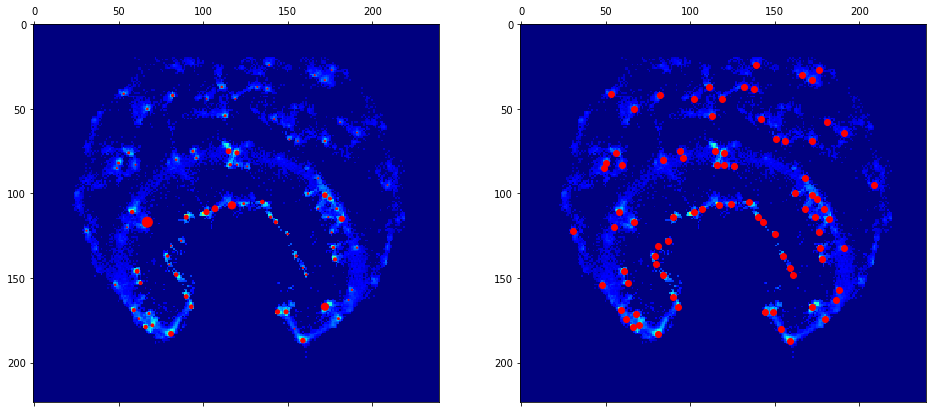

In [42]:
# Threshold average deconvolution maxima

minRelIntensity = 0.005
scale=100

deconvolution_peaks_thresh = deconvolution_peaks.copy()
deletemask = np.zeros(deconvolution_peaks_thresh.length, dtype=bool)
deletemask = deconvolution_peaks_thresh.data['intensity']/np.max(deconvolution_peaks_thresh.data['intensity']) < minRelIntensity
deconvolution_peaks_thresh.remove_points(deletemask)

# Show
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution**0.25,cmap='jet')
ax1.scatter(deconvolution_peaks_thresh.data['qy'],deconvolution_peaks_thresh.data['qx'],color='r',
            s=scale*deconvolution_peaks_thresh.data['intensity']/np.max(deconvolution_peaks_thresh.data['intensity']))
ax2.matshow(deconvolution**0.25,cmap='jet')
ax2.scatter(deconvolution_peaks_thresh.data['qy'],deconvolution_peaks_thresh.data['qx'],color='r')
plt.show()

In [66]:
# Make a Voronoi diagram

deconvolution_peaks_thresh.sort('intensity')
points = np.vstack((deconvolution_peaks_thresh.data['qx'],deconvolution_peaks_thresh.data['qy'])).T

voronoi = Voronoi(points)#, qhull_options='Qz QJ')

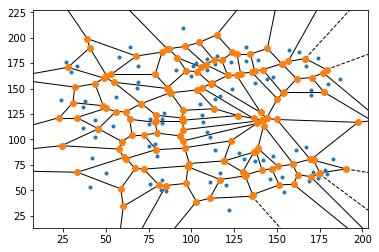

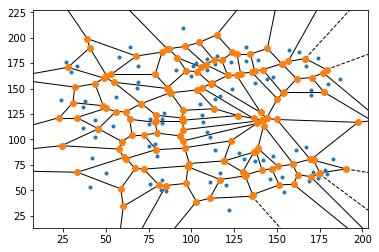

In [67]:
voronoi_plot_2d(voronoi)

In [68]:
# Let's see if we can make a mask for each Voronoi region...

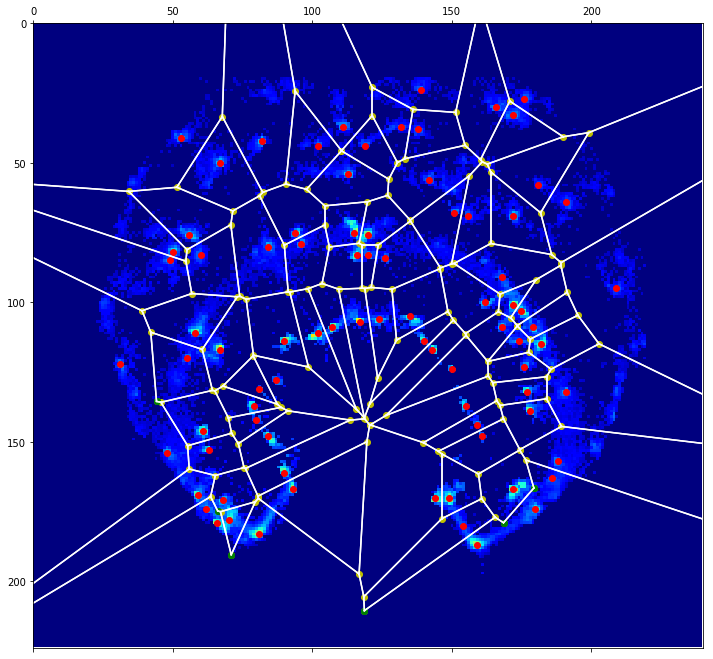

In [111]:

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(deconvolution**0.25,cmap='jet')
ax.scatter(voronoi.points[:,1],voronoi.points[:,0],color='r')
ax.scatter(voronoi.vertices[:,1],voronoi.vertices[:,0],color='y')

center = voronoi.points.mean(axis=0)
for region in voronoi.point_region:
    vor_vertex_indices = voronoi.regions[region]
    for i in range(len(vor_vertex_indices)):
        index0 = vor_vertex_indices[i]
        index1 = vor_vertex_indices[(i+1)%len(vor_vertex_indices)]
        if index0!=-1 and index1!=-1:
            x0,y0 = voronoi.vertices[index0]
            x1,y1 = voronoi.vertices[index1]
            ax.plot((y0,y1),(x0,x1),'w')
        else:
            # We need to define a point far away to connect to
            near_ind, far_ind = max(index0,index1),min(index0,index1) # identify which is -1
            

ax.set_xlim([0,deconvolution.shape[1]])
ax.set_ylim([0,deconvolution.shape[0]])
plt.gca().invert_yaxis()
plt.show()

In [91]:
voronoi.point_region

array([47, 84, 33, 77, 23, 42, 18, 76, 64, 13,  5, 10, 81, 43, 40, 46, 16,
       45, 61,  6, 72, 29, 73, 63, 50, 24, 17, 26, 82, 60, 49, 39, 28, 71,
       69,  8, 68,  2, 34, 83, 22, 70, 11, 38, 20,  9, 59, 51, 78, 37, 14,
       74, 79, 62, 31, 41, 30, 35, 27,  1, 25, 56, 67,  3, 48, 44, 65, 19,
       55, 58, 54, 32, 80, 15, 53, 52, 57,  7,  4, 66,  0, 12, 36, 21])

In [95]:
voronoi.regions[47]

[107, 54, 62, 63, 31, 32, 34, 35, 106]

In [98]:
voronoi.vertices[107]

array([119.16666667,  78.83333333])

In [114]:
voronoi.ridge_vertices

[[-1, 1],
 [-1, 3],
 [1, 2],
 [2, 9],
 [3, 10],
 [9, 10],
 [-1, 0],
 [0, 6],
 [-1, 14],
 [6, 15],
 [14, 15],
 [17, 19],
 [17, 18],
 [18, 20],
 [19, 20],
 [0, 19],
 [6, 7],
 [7, 17],
 [3, 11],
 [10, 22],
 [11, 23],
 [22, 23],
 [5, 28],
 [5, 8],
 [8, 16],
 [16, 25],
 [24, 25],
 [24, 26],
 [26, 27],
 [27, 29],
 [28, 29],
 [7, 32],
 [15, 31],
 [31, 32],
 [18, 36],
 [32, 34],
 [34, 36],
 [20, 21],
 [21, 37],
 [36, 37],
 [42, 43],
 [42, 44],
 [43, 45],
 [44, 45],
 [28, 51],
 [29, 49],
 [49, 51],
 [27, 46],
 [46, 48],
 [48, 50],
 [49, 50],
 [4, 5],
 [4, 53],
 [51, 53],
 [-1, 52],
 [-1, 4],
 [52, 53],
 [-1, 59],
 [21, 57],
 [57, 59],
 [14, 64],
 [31, 63],
 [63, 64],
 [8, 70],
 [16, 66],
 [66, 70],
 [61, 69],
 [61, 71],
 [69, 71],
 [-1, 61],
 [70, 71],
 [1, 38],
 [38, 73],
 [59, 60],
 [60, 72],
 [72, 73],
 [22, 75],
 [23, 74],
 [74, 75],
 [9, 76],
 [75, 76],
 [82, 84],
 [82, 83],
 [83, 86],
 [84, 85],
 [85, 86],
 [12, 13],
 [12, 82],
 [13, 39],
 [39, 84],
 [41, 80],
 [41, 83],
 [80, 81],
 [81, 

In [119]:
voronoi.points.mean(axis=0)

array([108.38095238, 122.11904762])

#### Construct set of Bragg peak indices found at each scan position

#### Define connection. Calculate between all adjacent pairs of scan positions.
Keep track of which values came from which scan position pairs.

#### Make histogram of connection values. Decide if this is one class or two+ class.

#### If two: draw a class-boundary line.
Begin by drawing a boundary separating the two scan positions with the lowest connection value. Iterate: at each boundary end, grow in one of the three possible directions, picking the direction of least connection. Grow until hitting a scan edge, or until intersecting with the boundary line itself.

#### Assign class identities (integers) the two new regions created.
For each new class: rinse, repeat. Finish when all classes are determined to be a single class.